# Heart Rate Zones Prediction

## Imports

In [2]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

# MODELS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Feature selection / dim red
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA; 
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = [10,5]

### Import and clean dataset

Import the dataset:

In [3]:
train = pd.read_csv('../input/statistical-learning-sapienza-spring-2022/train.csv')
test = pd.read_csv('../input/statistical-learning-sapienza-spring-2022/test.csv')

Inspect the data

In [4]:
train.head()

,id,y,from_start,month,day,sp.1,sp.2,sp.3,sp.4,sp.5,...,al.51,al.52,al.53,al.54,al.55,al.56,al.57,al.58,al.59,al.60
0,1,Zone-3,2135,Mar,Afternoon,2.790,2.790,2.845,2.852,2.900,...,23.4,23.2,23.2,23.2,23.4,23.4,23.4,23.4,23.2,23.2
1,2,Zone-3,4542,Nov,Morning,2.385,2.985,2.985,2.985,3.194,...,34.2,34.2,34.2,34.2,34.0,34.0,34.0,34.0,34.0,34.0
2,5,Zone-3,1340,May,Afternoon,3.362,3.362,3.394,3.480,3.498,...,22.6,22.8,22.6,22.6,22.4,22.4,22.4,22.4,22.4,22.2
3,6,Zone-4,2768,Feb,Morning,3.700,3.700,3.707,3.736,3.732,...,17.0,17.0,17.0,17.0,16.8,16.6,16.6,16.4,16.4,16.6
4,7,Zone-2,1718,Dec,Afternoon,2.497,2.497,2.596,2.751,2.767,...,42.4,42.4,42.0,41.8,41.6,41.6,41.4,41.4,41.2,41.2


#### Remove duplicate and fill NA. 

The NA are filled with the previous value in sequence (columns) since we treat the variable as time series, instead of filling with mean of columns/rows or remove. 

In [5]:
train.isna().sum().sort_values(ascending = False).head(25)

fcd.60    104
cs.60     104
cs.59     103
fcd.59    103
cs.58     100
fcd.58    100
fcd.55     98
fcd.31     98
cs.57      98
cs.56      98
cs.55      98
cs.31      98
fcd.57     98
fcd.56     98
fcd.28     97
cs.28      97
fcd.54     97
cs.54      97
cs.45      97
fcd.45     97
fcd.38     96
cs.53      96
cs.38      96
cs.46      96
fcd.46     96
dtype: int64

In [6]:
print( "Number of columns with NA: ", sum(train.isna().sum() != 0) ) # = columns with NA - 124
print( "Number of duplicate samples:", train.duplicated().sum() )     # No duplicate rows - 0

Number of columns with NA:  124
Number of duplicate samples: 0


In [7]:
# we fill the NA propagating forward the last valid observed value and not with the standard mean
train = train.fillna(method='ffill')

### Take a look at the empirical distribution of the response variable

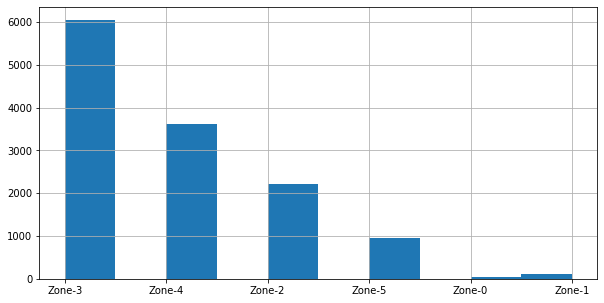

In [8]:
# Empirical distribution
train.y.hist();

We can see that we have very low observation for category 0 and 1. 

### Feature selection and model choice

The most important part of the overall process is the feature selection. 

Since we intend our model as a time series, we look at the autocorrelation plot among the 60seconds features, the values are high also even after a decent amount of lag. We decide then to reduce the autocorrelation thinning the features with a thin value equal to 5, which "smooths" the overall plot.

The features of interest are speed and altitude.

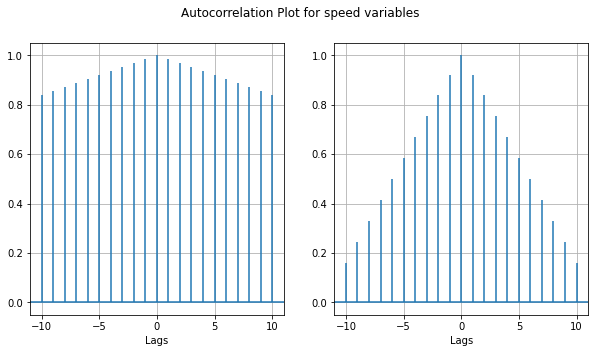

In [9]:
# Autocorrelation Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Autocorrelation Plot for speed variables")
ax1.acorr(train.iloc[0, 5:65],   maxlags = 10)
ax2.acorr(train.iloc[0, 5:65:5], maxlags = 10)
ax1.grid(True); ax2.grid(True)
ax1.set_xlabel("Lags"); ax2.set_xlabel("Lags")
plt.show()

Looking over forum of enthusiastic of cycling and running, we found out that the most important feature was the summation of cadence and fractional cadence was the summation of the two that is called SPM ( = cadence + fractional cadance).
Also here we choose to thinning this time series.

During our testing, we noticed that the usage of the variable "From_start" impact in a nice way the results. We will include this.

In the end we one-hot-encoding the categorical variable of Month and Day to be used in set of our features.

In [10]:
# retrieve columns name and group of features
columns = train.columns 

# Retrieve Fractional's and Cadence's variable 
cadence    = columns[65:125]
fractional = columns[125:185]

fractional_df = train.loc[:, fractional]
cadence_df    = train.loc[:, cadence]
# compute the SPM with lag
cad_plus_fract_w_lag = np.add(cadence_df.to_numpy(), fractional_df.to_numpy())[:, ::5]

# Retrive the Thinning Speed and Latitude
speed_lag      = columns[5:65:5]
altitude_lag   = columns[185:245:5]
# compute the speed with lag
speed_w_lag    = train.loc[:, speed_lag]
# compute the altitude with lag
altitude_w_lag = train.loc[:, altitude_lag]

# take the from_start variable
from_start = train.loc[:, "from_start"].to_numpy().reshape(-1,1)

# get dummies
month_dummies = pd.get_dummies(train.month, prefix='month')
day_dummies = pd.get_dummies(train.day, prefix='day')

Aggregate the selected features in a numpy array and separate features from response to prepare the data for the classifier.

In [11]:
x = np.concatenate([from_start,
                    month_dummies, day_dummies,
                    cad_plus_fract_w_lag, speed_w_lag, altitude_w_lag], axis = 1)

y = train['y'].to_numpy()

This are the features that we will use to tune and train the best model. We also treid to improve this selection by:
 
- inserting statistics about the variables (describe of the 60s speed/altitude)

- merging Month+Day and one hot encoding the "cartesian product"

- min-max Normalization + binning of the variables

- SVD or PCA on group of features or overall features

Despite most of those pipelines would've worked using the last models, during the two days long we preferred to stick with this stable preprocessing.

# Model Explanation

### The initial model selection

First of all we tried different methods like: SVC, Naive Bayes, KNN and Ridge Classification. 

The most unsatisfactor outcome was the Support Vector Machine which was able to have a good training score, but with a very poor prediction (predicts only in one class, sometimes two).

We discovered that the **most important** statistics to check if the slelcted model was good were:

- look at the score on the various folds (during training) along with the average score + standard deviation;
- plot of the empirical distribution on the test.


We can say that the best predictions were given by ensemble models: Random Forest, XGboost, LGBM (also tried Gradient Boosting and Boosting Classifier).

## LGBM model

After the tuning of the Random Forest, which we weren't able to improve, we tried investigating other models, for example LGBM.

Initialize the model with the dictionary of configuration to tune. Different tuning of parameters like: learning rate, regularization term, etc.. didn't improve at all the score beside the default configuration.

In [12]:
lgbm = LGBMClassifier(objective='multiclass', random_state=1234, n_jobs = -1)

params = { "n_estimators": [130,170,200,250], 
           "max_depth": [-1,20,25,30]
         }

Start the Grid Search:

In [13]:
grid_search = GridSearchCV(estimator = lgbm,
                   param_grid = params,
                   scoring = "f1_weighted",
                   cv = 5, verbose = 5, 
                    )
grid_search.fit(x, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....max_depth=-1, n_estimators=130;, score=0.744 total time=   3.6s
[CV 2/5] END ....max_depth=-1, n_estimators=130;, score=0.727 total time=   2.6s
[CV 3/5] END ....max_depth=-1, n_estimators=130;, score=0.725 total time=   2.6s
[CV 4/5] END ....max_depth=-1, n_estimators=130;, score=0.725 total time=   2.7s
[CV 5/5] END ....max_depth=-1, n_estimators=130;, score=0.739 total time=   2.6s
[CV 1/5] END ....max_depth=-1, n_estimators=170;, score=0.743 total time=   3.3s
[CV 2/5] END ....max_depth=-1, n_estimators=170;, score=0.734 total time=   4.0s
[CV 3/5] END ....max_depth=-1, n_estimators=170;, score=0.727 total time=   3.1s
[CV 4/5] END ....max_depth=-1, n_estimators=170;, score=0.728 total time=   4.0s
[CV 5/5] END ....max_depth=-1, n_estimators=170;, score=0.745 total time=  12.7s
[CV 3/5] END ....max_depth=-1, n_estimators=200;, score=0.729 total time=   3.9s
[CV 4/5] END ....max_depth=-1, n_estimators=200;

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='multiclass',
                                      random_state=1234),
             param_grid={'max_depth': [-1, 20, 25, 30],
                         'n_estimators': [130, 170, 200, 250]},
             scoring='f1_weighted', verbose=5)

Here we plot the results we achieve along with the standard deviation and the single score for each fit. The rows are ordered based on the average mean score of the KFold. 

The standard deviation columns help us choosing the first or second position model, based on the variance on the predicions. In fact sometimes we prefer a second position model which performs better than the first.

In [14]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score", axis = 0).head(5).iloc[:, 7:]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.743670,0.734051,0.729065,0.731882,0.744570,0.736648,0.006309,1
10,0.743670,0.734051,0.729065,0.731882,0.744570,0.736648,0.006309,1
14,0.743670,0.734051,0.729065,0.731882,0.744570,0.736648,0.006309,1
5,0.747771,0.730279,0.727123,0.724890,0.747488,0.735510,0.010043,4
1,0.742802,0.733806,0.727473,0.728133,0.744810,0.735405,0.007232,5


## The optimal model: XGBoost

Then we try a different model, XGboost. 

To use this model we need to pass labeled encoding response: "Zone-0"--> 0, "Zone-1"-->1, etc..

In [15]:
lookupTable, indexed_y = np.unique(y, return_inverse=True)

In [16]:
xgbust = xgb.XGBClassifier(n_jobs = 2, grow_policy = 'depthwise', booster = 'dart', random_state = 1234)

params = { "n_estimators": [70,90,160],  
           "max_depth": [5, 15],
           "reg_alpha": [0.1],
           'reg_lambda':[1, 4], 
         }

In [17]:
grid_search = GridSearchCV(estimator = xgbust,
                   param_grid = params,
                   scoring = "f1_weighted",
                   cv = 3, verbose = 5, 
                    )

grid_search.fit(x, indexed_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END max_depth=5, n_estimators=70, reg_alpha=0.1, reg_lambda=1;, score=0.720 total time=  15.4s
[CV 2/3] END max_depth=5, n_estimators=70, reg_alpha=0.1, reg_lambda=1;, score=0.719 total time=  16.2s
[CV 3/3] END max_depth=5, n_estimators=70, reg_alpha=0.1, reg_lambda=1;, score=0.725 total time=  15.6s
[CV 1/3] END max_depth=5, n_estimators=70, reg_alpha=0.1, reg_lambda=4;, score=0.723 total time=  16.3s
[CV 2/3] END max_depth=5, n_estimators=70, reg_alpha=0.1, reg_lambda=4;, score=0.713 total time=  15.8s
[CV 3/3] END max_depth=5, n_estimators=70, reg_alpha=0.1, reg_lambda=4;, score=0.718 total time=  16.4s
[CV 1/3] END max_depth=5, n_estimators=90, reg_alpha=0.1, reg_lambda=1;, score=0.725 total time=  23.1s
[CV 2/3] END max_depth=5, n_estimators=90, reg_alpha=0.1, reg_lambda=1;, score=0.715 total time=  23.5s
[CV 3/3] END max_depth=5, n_estimators=90, reg_alpha=0.1, reg_lambda=1;, score=0.723 total time=  23.5s
[CV

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='dart',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=No...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [18]:
pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score", axis = 0).head(5).iloc[:, 7:]

,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,4,"{'max_depth': 15, 'n_estimators': 160, 'reg_al...",0.724984,0.722734,0.730112,0.725943,0.003088,1
9,4,"{'max_depth': 15, 'n_estimators': 90, 'reg_alp...",0.723935,0.723213,0.728918,0.725355,0.002537,2
7,4,"{'max_depth': 15, 'n_estimators': 70, 'reg_alp...",0.723415,0.722092,0.726734,0.724080,0.001953,3
10,1,"{'max_depth': 15, 'n_estimators': 160, 'reg_al...",0.721722,0.720405,0.727970,0.723366,0.003299,4
8,1,"{'max_depth': 15, 'n_estimators': 90, 'reg_alp...",0.719475,0.720394,0.726097,0.721989,0.002929,5


What we notice is that also if we have a lower score, using a proper tuned model with a chosen regularization, we achieve better generalization in the model and better score. 

## Prediction

To predict on the test set we need to re-apply the whole preprocessing on this dataset:

In [19]:
id_ = test['id']
# fill with precedent value
test = test.fillna(method='ffill')

In [20]:
# 
columns_test = test.columns # retrieve columns 

# SPEED / ALTITUDE 
speed_lag = columns_test[4:64:5]
altitude_lag = columns_test[184:244:5]

speed_lag_df_test = test.loc[:, speed_lag]
altitude_lag_df_test = test.loc[:, altitude_lag]

# get dummies MONTH / DAY
month_dummies_test = pd.get_dummies(test.month, prefix='month')
day_dummies_test = pd.get_dummies(test.day, prefix='day')

# CADENCE / FRACTIONAL ---> +
cadence = columns_test[64:124]
fractional = columns_test[124:184]

cadence_sample_test = test.loc[:, cadence]
fractional_sample_test = test.loc[:, fractional]

cad_fract_lag_df_test = np.add(cadence_sample_test.to_numpy(), fractional_sample_test.to_numpy())[:, ::5]

from_start_test = test.loc[:, "from_start"].to_numpy().reshape(-1,1)


x_test = np.concatenate([from_start_test,
                         month_dummies_test, day_dummies_test, 
                         cad_fract_lag_df_test, speed_lag_df_test, altitude_lag_df_test],
                        axis = 1)

In [22]:
best_clf = grid_search.best_estimator_
pred_y = best_clf.predict(x_test)

In [23]:
id_ = np.array(id_)
df = pd.DataFrame(data = (np.vstack((id_, pred_y)).T), columns=["id", "target"])

Plotting of the Histogram about the empirical distribution of the predict to see the overall behavior and inspect the prediction we achieve.

<AxesSubplot:>

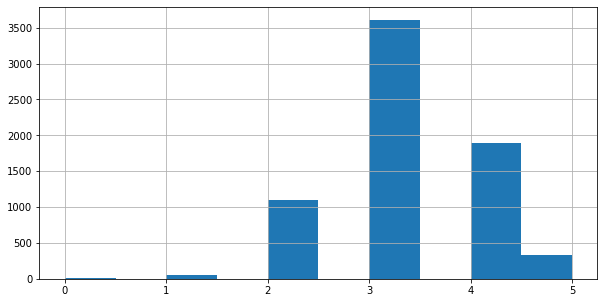

In [24]:
df.target.hist()